working good, increase training dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import os
from tensorflow.keras.utils import img_to_array
import matplotlib.pyplot as plt

def preprocess(img_path, target_size=(224, 224)):
    image = cv2.imread(img_path)
    image = cv2.resize(image, target_size)
    image = image / 255.0
    return img_to_array(image)

def preprocess_mask(mask_path, target_size=(224, 224)):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, target_size)
    mask = mask / 255.0
    mask = np.where(mask > 0.5, 1, 0).astype(np.float32)
    return np.expand_dims(mask, axis=-1)  # Add channel dimension for compatibility

image_path = "/content/drive/MyDrive/tusimple_preprocessed/final_x_train/0531_1492629622122282162.jpg"
mask_path = "/content/drive/MyDrive/tusimple_preprocessed/final_y_train/0531_1492629622122282162.jpg"
#image_path = '/content/drive/MyDrive/training/frames'
#mask_path = '/content/drive/MyDrive/training/lane-masks'


In [ ]:
#x_train_path = '/content/drive/MyDrive/tusimple_preprocessed/final_x_train'
#y_train_path = '/content/drive/MyDrive/tusimple_preprocessed/final_y_train'
x_train_path = '/content/drive/MyDrive/training/frames'
y_train_path = '/content/drive/MyDrive/training/lane-masks'

In [ ]:
import random

x_images = sorted(os.listdir(x_train_path))
y_images = sorted(os.listdir(y_train_path))

random_indices = random.sample(range(3600), 500)

x_data = [cv2.imread(os.path.join(x_train_path, x_images[i])) for i in random_indices]
y_data = [cv2.imread(os.path.join(y_train_path, y_images[i]), 0) for i in random_indices]

x_data = np.array(x_data)
y_data = np.array(y_data)


In [ ]:
len(x_data), len(y_data)

(500, 500)

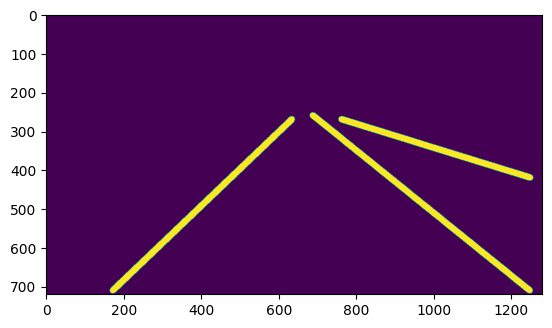

In [ ]:
plt.imshow(y_data[0])

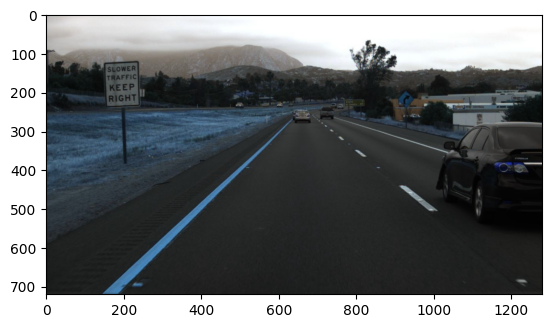

In [ ]:
plt.imshow(x_data[0])

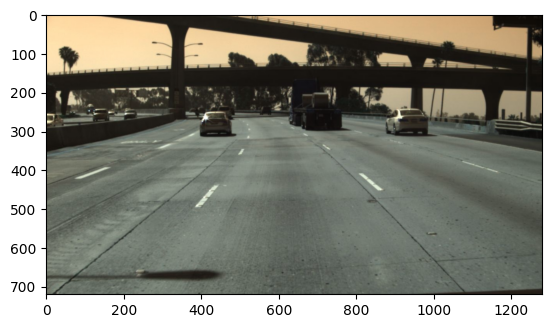

In [ ]:
plt.imshow(x_data[434])

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((400, 720, 1280, 3), (100, 720, 1280, 3), (400, 720, 1280), (100, 720, 1280))

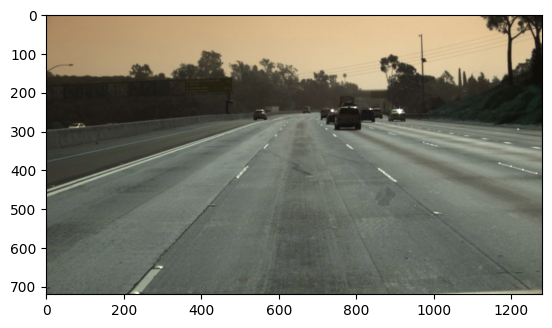

In [ ]:
plt.imshow(x_train[0])

In [ ]:
def preprocess_image(image, target_size=(224, 224)):
    image = cv2.resize(image, target_size)
    image = image / 255.0
    return img_to_array(image)

def preprocess_mask(mask, target_size=(224, 224)):
    mask = cv2.resize(mask, target_size)
    mask = mask / 255.0
    mask = np.where(mask > 0.5, 1, 0).astype(np.float32)
    return np.expand_dims(mask, axis=-1)

In [ ]:
x_train = np.array([preprocess_image(img) for img in x_train])
y_train = np.array([preprocess_mask(mask) for mask in y_train])
x_test = np.array([preprocess_image(img) for img in x_test])
y_test = np.array([preprocess_mask(mask) for mask in y_test])

In [ ]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((400, 224, 224, 3),
 (100, 224, 224, 3),
 (400, 224, 224, 1),
 (100, 224, 224, 1))

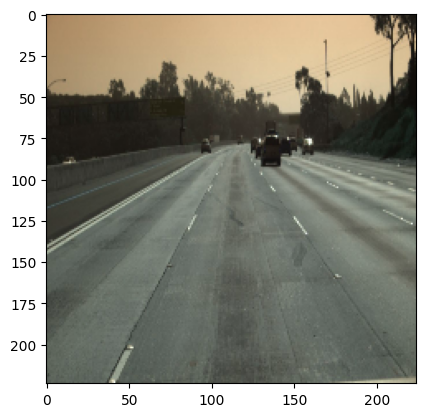

In [ ]:
plt.imshow(x_train[0])

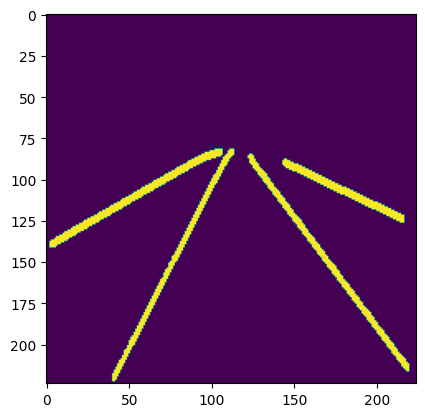

In [ ]:
plt.imshow(y_train[0])

In [ ]:
import glob, os
frame_files = sorted(glob.glob(os.path.join(x_train_path, '*.jpg')))
mask_files = sorted(glob.glob(os.path.join(y_train_path, '*.jpg')))

In [ ]:
len(frame_files),len(mask_files)

(3626, 3626)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model

def unet_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 28, 28, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 28, 28, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 14, 14, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 14, 14, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 14, 14, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 28, 28, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 28, 28, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10,
    batch_size=16
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.8224 - loss: 1.1633 - val_accuracy: 0.9577 - val_loss: 0.2112
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 640ms/step - accuracy: 0.9571 - loss: 0.2051 - val_accuracy: 0.9577 - val_loss: 0.1871
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 664ms/step - accuracy: 0.9573 - loss: 0.1947 - val_accuracy: 0.9577 - val_loss: 0.1821
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 658ms/step - accuracy: 0.9574 - loss: 0.1757 - val_accuracy: 0.9577 - val_loss: 0.1650
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 649ms/step - accuracy: 0.9572 - loss: 0.1612 - val_accuracy: 0.9577 - val_loss: 0.1490
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 646ms/step - accuracy: 0.9570 - loss: 0.1533 - val_accuracy: 0.9577 - val_loss: 0.1450
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 663ms/step - accuracy: 0.9575 - loss: 0.1422 - val_accuracy: 0.9577 - val_loss: 0.1381
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 672ms/step - accuracy: 0.9572 - loss: 0.1372 - val_accura

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

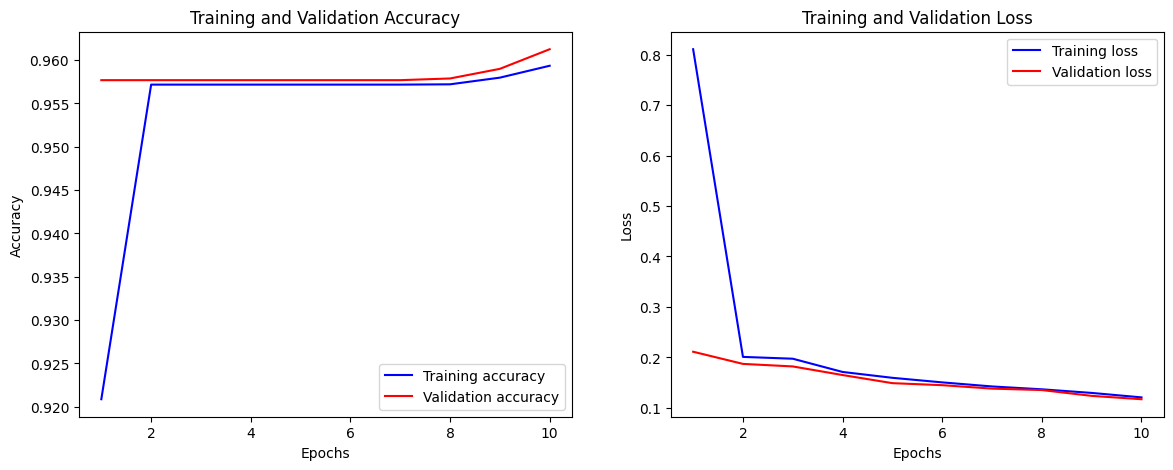

In [ ]:
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
input_image = '/content/drive/MyDrive/tusimple_preprocessed/final_x_train_2/0313-1_5580.jpg'

In [ ]:
img = preprocess(input_image)

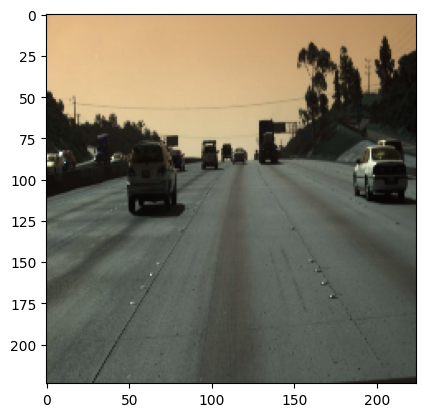

In [ ]:
plt.imshow(img)

In [ ]:
img.shape

(224, 224, 3)

In [ ]:
img = img.reshape(1, 224, 224, 3)

In [ ]:
new = model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [ ]:
new = new[0, :, :, 0]

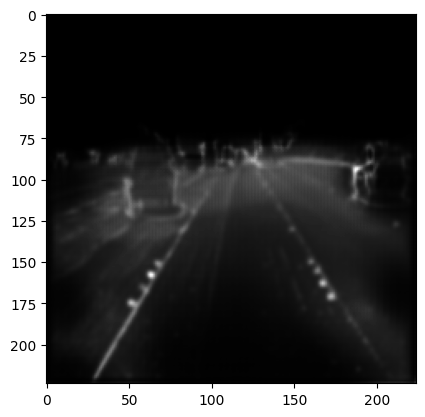

In [ ]:
plt.imshow(new,cmap = 'gray')

In [ ]:
import numpy as np

def preprocess_for_prediction(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)
    if img.shape[:2] != target_size:
        img = cv2.resize(img, target_size)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

img_preprocessed = preprocess_for_prediction(input_image)
new = model.predict(img_preprocessed)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


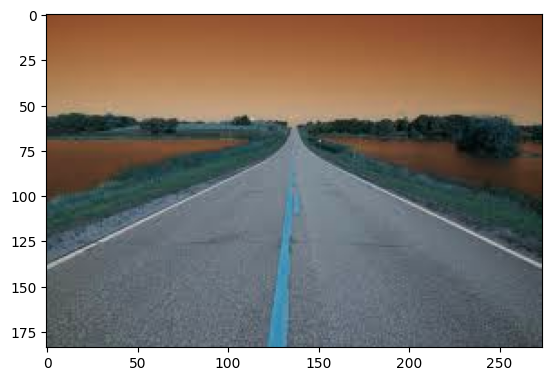

In [ ]:
test_img = cv2.imread('/content/images.jpeg')
plt.imshow(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


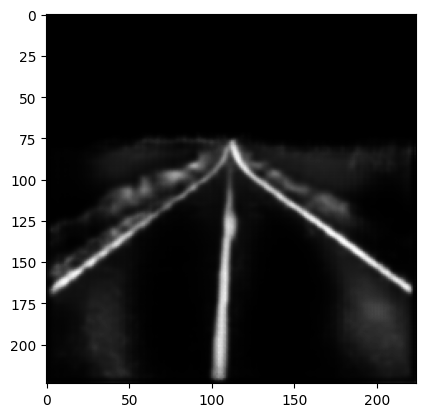

In [ ]:
test_img = preprocess('/content/images.jpeg')
test_img = test_img.reshape(1, 224, 224, 3)
test_img = model.predict(test_img)
test_img = test_img[0, :, :, 0]
plt.imshow(test_img,cmap = 'gray')

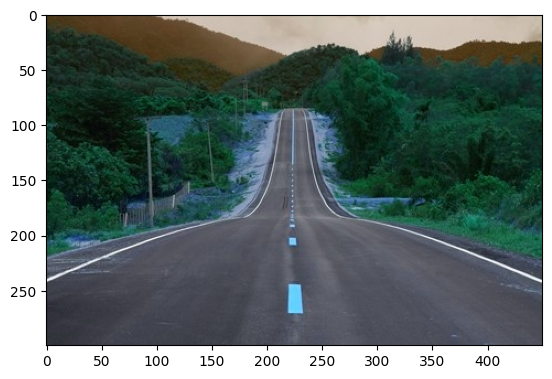

In [ ]:
test_img = cv2.imread('/content/0Yd5f.jpg')
plt.imshow(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


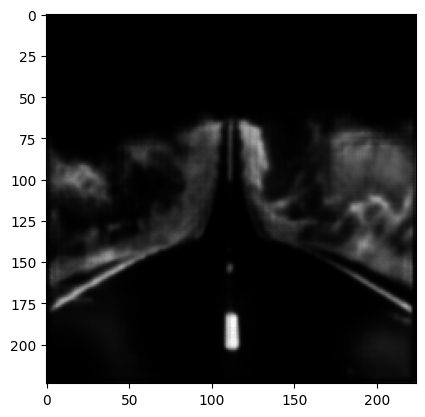

In [ ]:
test_img = preprocess('/content/0Yd5f.jpg')
test_img = test_img.reshape(1, 224, 224, 3)
test_img = model.predict(test_img)
test_img = test_img[0, :, :, 0]
plt.imshow(test_img,cmap = 'gray')

In [ ]:
input_image = preprocess('/content/images.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


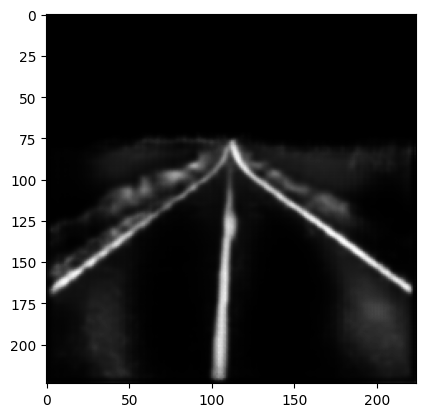

In [ ]:
test_img = preprocess('/content/images.jpeg')
test_img = test_img.reshape(1, 224, 224, 3)
test_img = model.predict(test_img)
test_img = test_img[0, :, :, 0]
plt.imshow(test_img,cmap = 'gray')

In [ ]:
test_img = test_img * 255

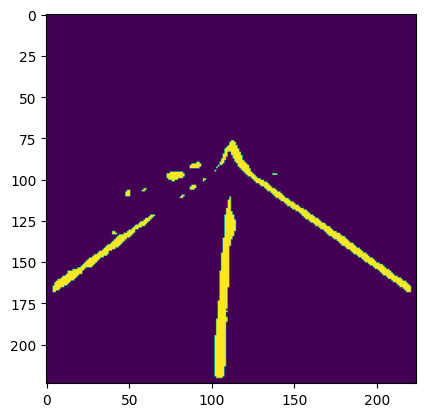

In [ ]:
import numpy as np
_, mask = cv2.threshold(test_img, 75, 200, cv2.THRESH_BINARY)

mask_colored = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

red_overlay = np.zeros_like(input_image)
red_overlay[:, :, 2] = mask
plt.imshow(mask)

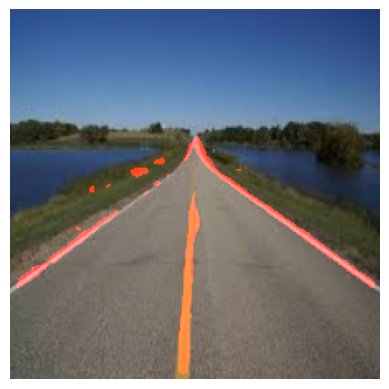

In [ ]:
highlighted = cv2.addWeighted(input_image, 1, red_overlay, 0.5, 0)

plt.imshow(cv2.cvtColor(highlighted, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
model.save('content/model_name.h5')


In [ ]:
import json
model_json = model.to_json()
with open("content/model_name.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
model.save_weights("content/model.weights.h5")
